<a href="https://colab.research.google.com/github/Rezixx/Studienarbeit_Pred_Analytics/blob/main/Data_Understanding_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import duckdb
# Set seed for reproducibility
np.random.seed(42)  # Set seed for NumPy
random.seed(42) # Set seed for random module

#Read Survey Data
survey = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/survey_data/survey_responses.csv?")
#Read energy consumption data
energy = pd.read_csv("https://media.githubusercontent.com/media/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/sensor_data/household_sensors_electric.csv?token=A7LWR6CLVJ5UB3MYLMPXF2LHJYKMQ")
home = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/home.csv?")
home["income_band"].isna().sum()

0

In [ ]:
# Setup DuckDB for home.csv
db = duckdb.connect(database= 'home.duckdb')

#file = 'home.csv'
#result = db.execute(f"SELECT homeid, income_band  FROM read_csv_auto('{file}')").fetchdf()

result_grouped = home[["homeid", "income_band"]].groupby('homeid', as_index=False).sum()

result_grouped = result_grouped.rename(columns={'homeid': 'home'})
result_grouped.head()

,home,income_band
0,47,Missing
1,59,"£90,000 or more"
2,61,"£48,600 to £53,999"
3,62,"£43,200 to £48,599"
4,63,"£54,000 to £65,999"


#Group electricity consumption by home


In [ ]:
total_consumption_per_home = energy.groupby('consumer_id', as_index=False)['total_consumption_Wh'].sum()
total_consumption_per_home['home'] = total_consumption_per_home['consumer_id'].str.extract('(\d+)').astype(int)
total_consumption_per_home = total_consumption_per_home.drop(columns=['consumer_id'])
total_consumption_per_home

,total_consumption_Wh,home
0,2819.138587,100
1,1693.315182,101
2,7525.694865,102
3,1849.203874,105
4,1797.777893,106
...,...,...
249,3030.517598,94
250,4922.948178,96
251,4585.916936,97
252,1457.899292,98


#Plot electricity consumption in histogram

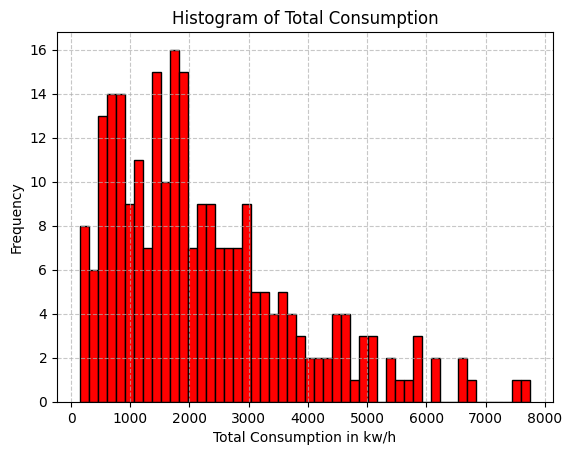

In [ ]:
plt.hist(total_consumption_per_home['total_consumption_Wh'], bins=50, edgecolor='black', color='red')
plt.title('Histogram of Total Consumption')
plt.xlabel('Total Consumption in kw/h')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Number of appliances per household scatterplot


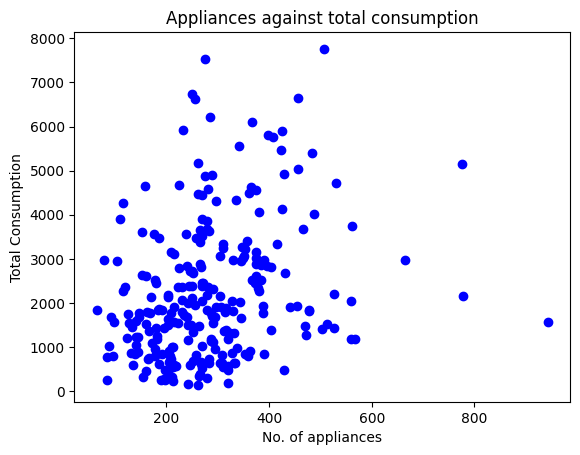

In [ ]:
appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/appliance.csv")
other_appliances = pd.read_csv("https://raw.githubusercontent.com/Rezixx/Studienarbeit_Pred_Analytics/refs/heads/main/metadata/other_appliance.csv")

appliances = appliances[appliances['powertype'] == 'electric']
appliances = appliances.drop(columns=['appliancetype', 'applianceclass', 'appliancesubtype', 'roomid'])
no_appliances = appliances.groupby('homeid', as_index=False).size()
appliances = pd.merge(appliances, no_appliances, on='homeid')
appliances['amount'] = appliances["size"] * appliances["number"]
appliances_group = appliances.groupby('homeid', as_index=False)['amount'].sum()

other_appliances['num_clean'] = other_appliances['number'].str.replace(r'\D', '', regex=True)
other_appliances['num_clean'] = other_appliances['num_clean'].astype(int)
no_other_appliances = other_appliances.groupby('homeid', as_index=False).size()
other_appliances = pd.merge(other_appliances, no_other_appliances, on='homeid')
other_appliances['amount'] = other_appliances["size"] * other_appliances["num_clean"]
other_appliances_group = other_appliances.groupby('homeid', as_index=False)['amount'].sum()
other_appliances_group

appliances_merged = pd.merge(appliances_group, other_appliances_group, on='homeid', how='inner')
appliances_merged['total_appliances'] = appliances_merged['amount_x'] + appliances_merged['amount_y']
appliances_merged = appliances_merged.drop(columns=['amount_x', 'amount_y'])
appliances_merged = appliances_merged.rename(columns={'homeid': 'home'})
appliances_merged
# END OF PREPROCESSING
total_consumption_per_home_appliances = pd.merge(total_consumption_per_home, appliances_merged, on='home', how='inner')
total_consumption_per_home_appliances

# Plot appliances against energy consumption
plt.scatter(total_consumption_per_home_appliances['total_appliances'], total_consumption_per_home_appliances['total_consumption_Wh'], color='blue')
plt.title('Appliances against total consumption')
plt.xlabel('No. of appliances')
plt.ylabel('Total Consumption')
plt.show()

#Create Test and Trainings splits

In [ ]:
from sklearn.model_selection import train_test_split

# Merge both Frames
income_energy_home = pd.merge(result_grouped, total_consumption_per_home, on='home', how='inner')

# Split into train, test
training_data_cat, test_data_cat = train_test_split(income_energy_home, test_size=0.2, random_state=42)

# Merge both Frames together and use dummy encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)

# Fit and transform the training data
encoded_training = encoder.fit_transform(training_data_cat[["income_band"]])
# Create a DataFrame with the encoded variables
encoded_training_df = pd.DataFrame(encoded_training, columns=encoder.get_feature_names_out(["income_band"]))
encoded_training_df.columns = encoded_training_df.columns.str.replace(" ", "_", regex=True)
encoded_training_df.columns = encoded_training_df.columns.str.replace("£", "", regex=True)
encoded_training_df.columns = encoded_training_df.columns.str.replace(",", "", regex=True)

# Join the encoded variables to the original DataFrame and remove the original columns
training_data_cat = training_data_cat.reset_index(drop=True).join(encoded_training_df).drop(columns=["income_band"])

# Transform the test data
encoded_test = encoder.transform(test_data_cat[["income_band"]])

encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(["income_band"]))

encoded_test_df.columns = encoded_test_df.columns.str.replace(" ", "_", regex=True)
encoded_test_df.columns = encoded_test_df.columns.str.replace("£", "", regex=True)
encoded_test_df.columns = encoded_test_df.columns.str.replace(",", "", regex=True)

test_data_cat = test_data_cat.reset_index(drop=True).join(encoded_test_df).drop(columns=["income_band"])


# Apply Linear Regression and evaluate Model performance

In [ ]:
from statsmodels.formula.api import ols

# Deselecting columns that should not be used as features
subset_train_X = training_data_cat.drop(columns=["home", "total_consumption_Wh"])
feature_columns = list(subset_train_X.columns)

# Add all selected features to the formula
formula_str = "total_consumption_Wh ~ " + " + ".join(feature_columns)
print(formula_str)

model_01 = ols(formula=formula_str, data=training_data_cat)
model_01 = model_01.fit()
print(model_01.summary(slim=True))

total_consumption_Wh ~ income_band_less_than_10800 + income_band_10800_to_13499 + income_band_13500_to_16199 + income_band_16200_to_19799 + income_band_19800_to_23399 + income_band_23400_to_26999 + income_band_27000_to_32399 + income_band_32400_to_37799 + income_band_37800_to_43199 + income_band_43200_to_48599 + income_band_48600_to_53999 + income_band_54000_to_65999 + income_band_66000_to_77999 + income_band_78000_to_89999 + income_band_90000_or_more
                             OLS Regression Results                             
Dep. Variable:     total_consumption_Wh   R-squared:                       0.155
Model:                              OLS   Adj. R-squared:                  0.087
No. Observations:                   203   F-statistic:                     2.282
Covariance Type:              nonrobust   Prob (F-statistic):            0.00549
                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

## Calculate RMSE

In [ ]:
from sklearn.metrics import root_mean_squared_error

subset_test_X = test_data_cat.drop(columns=["home", "total_consumption_Wh"])
test_data_cat["total_consumption_Wh_pred"] = model_01.predict(test_data_cat)

rmse = root_mean_squared_error(test_data_cat["total_consumption_Wh"], test_data_cat["total_consumption_Wh_pred"])
print(rmse)

1903.507200195281


Der RMSE ist wirklich bodenlos schlecht, auch wenn unsere Skala durch Energiedaten recht hoch ist. Zusammen mit dem R-squared ist das Modell bisher nicht so aussagekräftig

## Plot Pearson coefficient
Zuerst Einkommensdaten anpassen, sodass wir Zahlen für die Spannen haben, und dann den Pearson Koeffizient plotten.

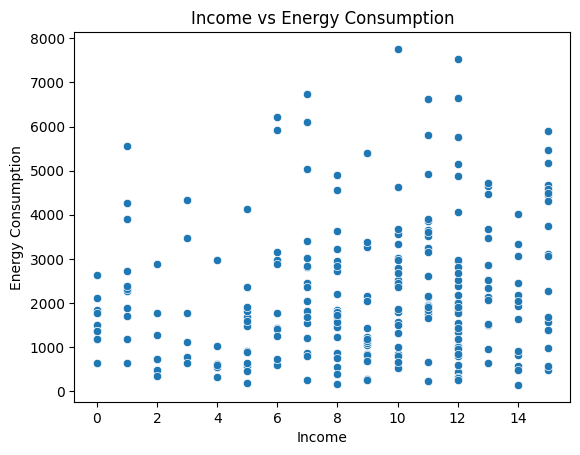

Pearson-Korrelationskoeffizient: 0.17164087907886635
P-Wert: 0.006099313759220993


In [ ]:
import seaborn as sns
from scipy.stats import pearsonr

income_midpoints = {
    "Missing": 0,
    "less than £10,800": 1,
    "£10,800 to £13,499": 2,
    "£13,500 to £16,199": 3,
    "£16,200 to £19,799": 4,
    "£19,800 to £23,399": 5,
    "£23,400 to £26,999": 6,
    "£27,000 to £32,399": 7,
    "£32,400 to £37,799": 8,
    "£37,800 to £43,199": 9,
    "£43,200 to £48,599": 10,
    "£48,600 to £53,999": 11,
    "£54,000 to £65,999": 12,
    "£66,000 to £77,999": 13,
    "£78,000 to £89,999": 14,
    "£90,000 or more": 15
}

income_energy_home["income_band_mid"] = income_energy_home["income_band"].map(income_midpoints)

sns.scatterplot(x='income_band_mid', y='total_consumption_Wh', data=income_energy_home)
plt.title("Income vs Energy Consumption")
plt.xlabel("Income")
plt.ylabel("Energy Consumption")
plt.show()

# Korrelation berechnen
correlation, p_value = pearsonr(income_energy_home["income_band_mid"], income_energy_home['total_consumption_Wh'])

# Ergebnisse anzeigen
print(f"Pearson-Korrelationskoeffizient: {correlation}")
print(f"P-Wert: {p_value}")

## Plot appliances against income


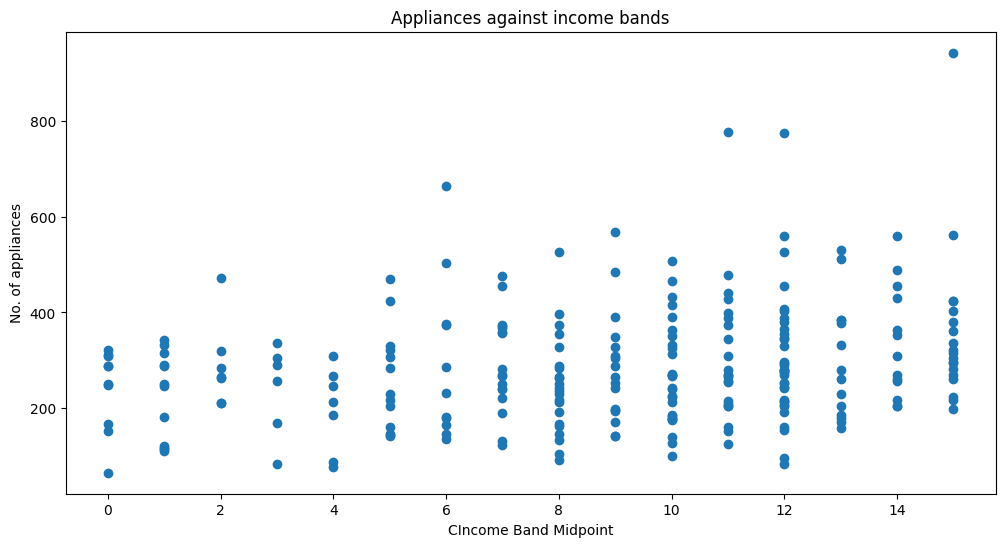

In [ ]:
appliance_income = pd.merge(appliances_merged, income_energy_home, on='home', how='inner')
appliance_income = appliance_income.drop(columns=['home'])
appliance_income.drop(columns=['income_band', 'total_consumption_Wh'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(appliance_income['income_band_mid'], appliance_income['total_appliances'])
#ax.boxplot(appliance_income)

ax.set_title('Appliances against income bands')
ax.set_xlabel('CIncome Band Midpoint')
ax.set_ylabel('No. of appliances')
plt.show()


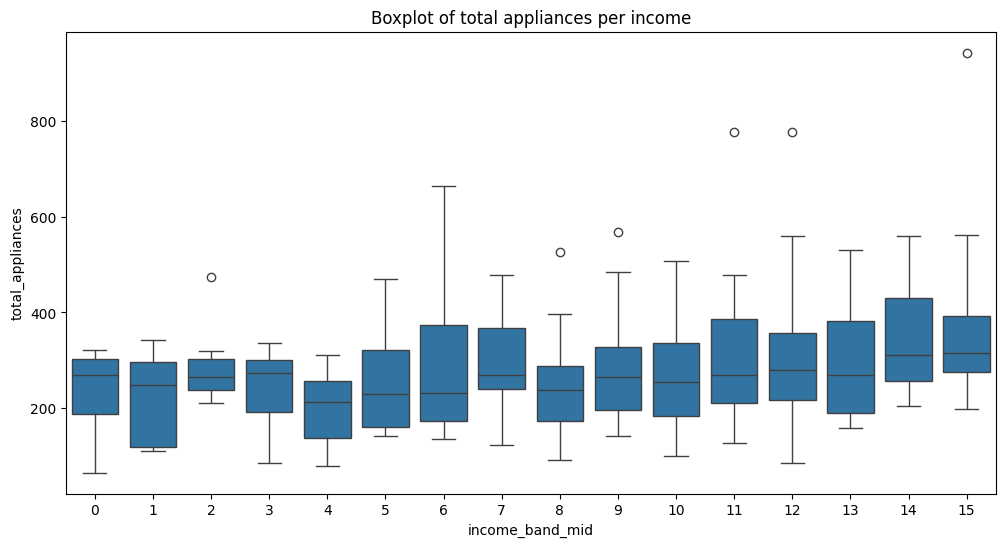

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='income_band_mid', y='total_appliances', data=appliance_income, ax=ax)

# Set the title of the plot
ax.set_title("Boxplot of total appliances per income")

# Show the plot
plt.show()